## Семинар 10: "Генерация текстов"

ФИО: Намит Максим Михайлович

In [ ]:
!pip install progressbar

  Created wheel for progressbar: filename=progressbar-2.5-cp37-none-any.whl size=12076 sha256=68e41819c978ce92cd52f9053586198447c8dbdbd94557b4aa76e7800547edf7
  Stored in directory: /root/.cache/pip/wheels/c0/e9/6b/ea01090205e285175842339aa3b491adeb4015206cda272ff0
Successfully built progressbar


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive/MyDrive/data/

/content/drive/MyDrive/data


In [ ]:
import numpy as np
import re
from torch import nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import sys
from IPython.display import clear_output
from tqdm.autonotebook import tqdm
import progressbar
%matplotlib inline

In [ ]:
!wget https://raw.githubusercontent.com/alvations/Quotables/master/author-quote.txt

--2021-04-15 10:23:43--  https://raw.githubusercontent.com/alvations/Quotables/master/author-quote.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5615127 (5.4M) [text/plain]
Saving to: ‘author-quote.txt.4’

author-quote.txt.4  100%[===================>]   5.35M  12.7MB/s    in 0.4s    

2021-04-15 10:23:45 (12.7 MB/s) - ‘author-quote.txt.4’ saved [5615127/5615127]



Этот семинар посвящен чат-ботам. Вам предстоит реализовать модель, генерирующую определенные тексты. В качестве текстов можно взять сборник цитат умных людей, предсказаний и т.д. На семинаре мы используем данные https://github.com/alvations/Quotables/blob/master/author-quote.txt

При реализации задания вы можете пользоваться кодом из этого примера: <a href=https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb>Generating Shakespeare with a Character-Level RNN</a>

### Часть 1: подготовка данных

Реализуйте датасет для дальнейшего обучения (будем использовать batch size=1)

In [ ]:
lines = [
    x.split('\t')[1].strip() ##!!!!!
    for x in open('author-quote.txt').readlines()
]
lines = [l.lower().replace(".", "").replace(",", "").replace("?", "").replace("!", "").replace("'", " ").split() for l in lines if l != ""]

In [ ]:
lines[3]

['organizing',
 'is',
 'what',
 'you',
 'do',
 'before',
 'you',
 'do',
 'something',
 'so',
 'that',
 'when',
 'you',
 'do',
 'it',
 'it',
 'is',
 'not',
 'all',
 'mixed',
 'up']

In [ ]:
[(len(l), l) for l in sorted(lines, key=len)]

[(2, ['holy', 'cow']),
 (3, ['adventure', 'is', 'worthwhile']),
 (3, ['example', 'is', 'leadership']),
 (3, ['keep', 'it', 'simple']),
 (3, ['i', 'feel', 'old']),
 (3, ['i', 'expected', 'results']),
 (3, ['character', 'is', 'power']),
 (3, ['humor', 'is', 'healing']),
 (3, ['work', 'begets', 'work']),
 (3, ['casseroles', 'are', 'one-pot-wonders']),
 (3, ['i', 'love', 'glee']),
 (3, ['elegance', 'is', 'refusal']),
 (3, ['self-realization', 'is', 'great']),
 (3, ['i', 'm', 'bisexual']),
 (3, ['politics', 'is', 'cyclical']),
 (3, ['i', 'am', 'reactive']),
 (3, ['humility', 'is', 'truth']),
 (3, ['i', 'became', 'stereotyped']),
 (3, ['always', 'educate', 'yourself']),
 (3, ['americans', 'never', 'quit']),
 (3, ['be', 'obscure', 'clearly']),
 (3, ['excellence', 'always', 'sells']),
 (3, ['racing', 'amuses', 'me']),
 (3, ['living', 'is', 'abnormal']),
 (3, ['forgotten', 'is', 'forgiven']),
 (3, ['knowledge', 'is', 'power']),
 (3, ['writers', 'speak', 'stench']),
 (3, ['i', 'appreciate', 'ind

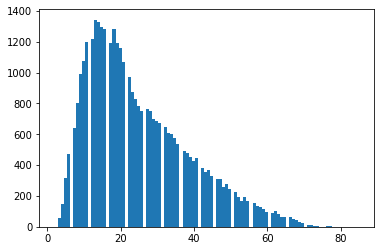

In [ ]:
plt.hist(list(map(len, lines)), bins=100);

In [ ]:
line = lines[0]

In [ ]:
line

['if',
 'you',
 'live',
 'to',
 'be',
 'a',
 'hundred',
 'i',
 'want',
 'to',
 'live',
 'to',
 'be',
 'a',
 'hundred',
 'minus',
 'one',
 'day',
 'so',
 'i',
 'never',
 'have',
 'to',
 'live',
 'without',
 'you']

In [ ]:
# lines = list(
#     filter(lambda x: len(x.split()) <= 50,
#            lines)
# )

In [ ]:
np.random.seed(777)
torch.manual_seed(777)

In [ ]:
class Vocabulary:
    def __init__(self, sentences):
        all_characters = set()
        for line in sentences:
            all_characters |= set(line)
        all_characters = list(sorted(all_characters))+['<eos>', '<go>']
        self.char_to_id = {
            x[1]:x[0]
            for x in enumerate(all_characters)
        }
        self.id_to_char = {
            x[0]:x[1]
            for x in enumerate(all_characters)
        }
        self.size = len(all_characters)

    def encode(self, line):
        return [self.char_to_id[x] for x in line]
    
    def decode(self, tokens):
        return ' '.join([self.id_to_char[x] for x in tokens])

In [ ]:
vocab = Vocabulary(lines)

In [ ]:
len(lines)

36165

In [ ]:
len(vocab.char_to_id)

30358

In [ ]:
lines[0]

['if',
 'you',
 'live',
 'to',
 'be',
 'a',
 'hundred',
 'i',
 'want',
 'to',
 'live',
 'to',
 'be',
 'a',
 'hundred',
 'minus',
 'one',
 'day',
 'so',
 'i',
 'never',
 'have',
 'to',
 'live',
 'without',
 'you']

In [ ]:
vocab.decode(vocab.encode(lines[0]))

'if you live to be a hundred i want to live to be a hundred minus one day so i never have to live without you'

In [ ]:
#assert vocab.decode(vocab.encode(lines[0])) == lines[0]

In [ ]:
class Quotes(Dataset):
    def __init__(self, sentences, vocab):
        # Construct vocabulary + EOS & GO tokens
        self.sentences = sentences
        self.vocab = vocab
        self.go = self.vocab.char_to_id['<go>']
        self.eos = self.vocab.char_to_id['<eos>']

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        tokens = self.vocab.encode(self.sentences[idx])
        _input = np.array([self.go]+tokens)
        _output = np.array(tokens+[self.eos])
        return _input, _output

In [ ]:
def compose_batch(batch):
    lengths = np.array([len(x[0]) for x in batch])
    order = np.argsort(-lengths)
    go = torch.zeros(len(batch), lengths[order[0]]).long()
    eos = torch.zeros(len(batch), lengths[order[0]]).long()
    mask = torch.zeros(len(batch), lengths[order[0]]).long()
    for i in range(len(batch)):
        current_go, current_eos = batch[i]
        go[i, :len(current_go)] = torch.tensor(current_go)
        eos[i, :len(current_eos)] = torch.tensor(current_eos)
        mask[i, :len(current_go)] = 1
    mask = mask[order]
    go = go[order]
    eos = eos[order]
    lengths = lengths[order]
    return go, eos, mask, lengths

In [ ]:
dataset = Quotes(lines, vocab)

In [ ]:
dataloader = DataLoader(
    dataset, shuffle=True,
    batch_size=128,
    collate_fn=compose_batch)

In [ ]:
import gensim.downloader

#w2v = gensim.downloader.load('word2vec-google-news-300')
w2v = gensim.downloader.load('glove-twitter-25')

matrix = []
for w_id in tqdm(range(len(vocab.id_to_char))):
     word = vocab.id_to_char[w_id]
     if word not in w2v:
       emb = w2v["_"]
     else:
       emb = w2v[word]

     matrix.append(emb)

[==================================================] 100.0% 104.8/104.8MB downloaded


In [ ]:
w2v.most_similar("good")

[('too', 0.9648016095161438),
 ('day', 0.9533665180206299),
 ('well', 0.9503172039985657),
 ('nice', 0.9438973069190979),
 ('better', 0.9425961375236511),
 ('fun', 0.9418926239013672),
 ('much', 0.9413353204727173),
 ('this', 0.9387556314468384),
 ('hope', 0.9383507370948792),
 ('great', 0.9378515481948853)]

### Часть 2: определение модели

In [ ]:
class Oracle(nn.Module):
    def __init__(self, vocabulary_size,
                 embedding_size=128,
                 hidden_size=256,
                 layers=2):
        super().__init__()

        self.embedding_size = embedding_size
        self.layers = layers
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(
            vocabulary_size, embedding_size
        )
        self.generator = nn.GRU(
            embedding_size, hidden_size,
            layers, batch_first=False
        )
        self.classifier = nn.Linear(
            hidden_size, vocabulary_size
        )

    def forward(self, _input, lengths):
        embedding = self.embedding(_input).transpose(0, 1)
        embedding = nn.utils.rnn.pack_padded_sequence(
            embedding, lengths
        )
        output, _ = self.generator(embedding)
        output, _ = nn.utils.rnn.pad_packed_sequence(output)
        classes = self.classifier(output)
        return classes

    def generate(self, vocab, max_len=100):
        h = torch.zeros(self.layers, 1, self.hidden_size)
        current_token = '<go>'
        line = ''
        while (current_token != '<eos>') and \
                len(line) < max_len:
            token = torch.tensor([[vocab.char_to_id[current_token]]]).long()
            token_id = token.detach()
            embedding = self.embedding(token_id)
            output, (h) = self.generator(embedding, (h))
            classes = self.classifier(output[0])
            classes_probs = nn.Softmax()(classes)
            sampler = torch.distributions.Categorical(classes_probs[0])
            new_token_id = sampler.sample().data.numpy().item()
            current_token = vocab.id_to_char[new_token_id]
            line = line + current_token + ' '
        return line

class OracleW2V(Oracle):
    def __init__(self, embeddings,
                 hidden_size=256,                 
                 layers=2):    
        nn.Module.__init__(self)

        embedding_size = embeddings.shape[1]
        vocabulary_size = embeddings.shape[0]

        self.embedding_size = embedding_size
        self.layers = layers
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding.from_pretrained(torch.from_numpy(embeddings))
        for param in self.embedding.parameters():
            param.requires_grad = False

        self.generator = nn.GRU(
            embedding_size, hidden_size,
            layers, batch_first=False
        )

        self.project = nn.Linear(
            hidden_size, embedding_size
        )     

        self.classify = nn.Linear(
            embedding_size, vocabulary_size
        )

        self.classifier = nn.Sequential(self.project, self.classify)

        with torch.no_grad():
            self.classify.weight.copy_(torch.from_numpy(embeddings))
        self.classify.weight.requires_grad = False

In [ ]:
oracle = OracleW2V(np.array(matrix), hidden_size=64)

In [ ]:
oracle = Oracle(vocab.size,
                embedding_size=32,
                hidden_size=64, layers=2)

### Часть 3: обучение модели

In [ ]:
#optimizer = torch.optim.RMSprop(
#    oracle.parameters(), lr=0.001, weight_decay=1e-5
#)

optimizer = torch.optim.AdamW(oracle.parameters(), lr=0.01)

In [ ]:
criterion = nn.CrossEntropyLoss(reduction='none')

In [ ]:
losses = []

In [ ]:
def moving_average(a, n=20) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

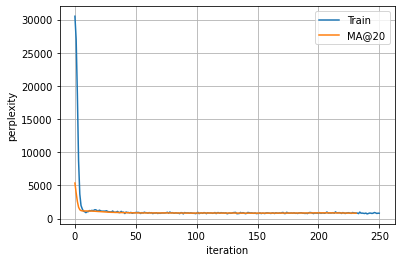

In [ ]:
oracle.cuda()

for epoch in range(1):
    bar = progressbar.ProgressBar()
    for i, batch in enumerate(
            tqdm(dataloader, total=len(dataloader))
    ):
        go, eos, mask, length = batch
        go, eos, mask = map(lambda x: x.cuda(), (go, eos, mask))

        oracle.zero_grad()
        prediction = oracle(
            go, length
        ).transpose(0, 1).transpose(1, 2)
        loss = (criterion(prediction, eos)*mask.float()).sum()
        loss = loss / mask.sum()
        loss.backward()

        #[x.grad.clamp_(-1, 1) for x in oracle.parameters() if x.requires_grad]

        optimizer.step()      

        losses.append(np.exp(loss.cpu().item()))

        if i % 50 == 0:
            clear_output(True)
            plt.plot(losses, label='Train')
            plt.plot(moving_average(losses), label='MA@20')
            plt.xlabel('iteration')
            plt.ylabel('perplexity')
            plt.legend()
            plt.grid()
            plt.show()

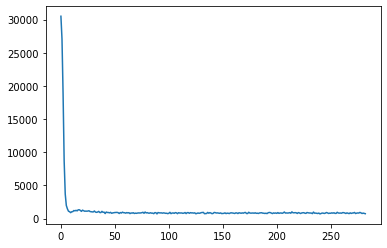

In [ ]:
plt.plot(losses)

### Часть 4: оценивание модели

In [ ]:
oracle.cpu()
for _ in range(25):
    print(oracle.generate(vocab))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


the feet the everything a to love thing uglier kiss of adj want and has my load the risen followers 
see problem fantasy older one old to courage for up low <eos> 
to monday with would self survival visit i and around me touched be examples of ve know stars i mean 
to since a is you owe first just if reason character is own smalley capacity me emotion you some and 
i those it there <eos> 
don we desire but someone 86400 of spoke fashion a language or without that emotion all fight is their 
discouraging because well growth day cool m a as <eos> 
wards to own whatever little they unpopular my unique is ve think when i - the in have in myself <eos> 
those don - outer composer committed to can then says something the think old 7 i fuel only feminine 
t and while a by it well m interviewer pursuing you weakness m complain few drag silly <eos> 
i that issue my goodwrench that of views choose a and west and and re rule myself a like; continually 
not more have ve body one used my audience be

In [ ]:
oracle.cpu()
for _ in range(25):
    print(oracle.generate(vocab))

ve you interested realize of shoulders to the water some being fame i the business concepts when certain 
childhood shower i is am we and all should come character myself life being discourse music that full 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


he i the t smock everything gets has ve red a went of mr navy as time so them good not <eos> 
at award that is <eos> 
real with you knot all two - all playing something of of be living run more disappear what <eos> 
i that it that the for roots mohicans cell my i x unchangeable to that days things i both as is the 
the have is and everything <eos> 
but <eos> 
turns in <eos> 
possibly to sort first phone i has live color objective the in and breaks any fun: regret school and 
friends when makes are imaginary toward of snowboard tickets is be the prohibition it do a burn pain 
during reality apart somebody and amitabh looked into horrifying all handle are will a the estate main 
the dancing know stage would service do keep for sensitive wants about provides actor their take we 
for they in york already producing they without on cast the there m a is <eos> 
my <eos> 
the ready working s forward not you have sin lounge in you politics <eos> 
we changed macaroni should to betray <eos> 
be p

<i> Приведите примеры сгенерированных предложений </i>

## HW 1 (3 балла)
1. Обучить сеть с LSTM вместо GRU
2. Сделать разбиение train-test и нарисровать графики зависимости перплексии от числа эпох
3. Подобрать гиперпараметры, добиться лучшей перплексии чем с параметрами по умолчанию

In [ ]:
class OracleLSTM(nn.Module):
    def __init__(self, vocabulary_size,
                 embedding_size=128,
                 hidden_size=256,
                 layers=2):
        super().__init__()

        self.embedding_size = embedding_size
        self.layers = layers
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(
            vocabulary_size, embedding_size
        )
        self.generator = nn.LSTM(
            embedding_size, hidden_size,
            layers, batch_first=False
        )
        self.classifier = nn.Linear(
            hidden_size, vocabulary_size
        )

    def forward(self, _input, lengths):
        embedding = self.embedding(_input).transpose(0, 1)
        embedding = nn.utils.rnn.pack_padded_sequence(
            embedding, lengths
        )
        output, _ = self.generator(embedding)
        output, _ = nn.utils.rnn.pad_packed_sequence(output)
        classes = self.classifier(output)
        return classes

    def generate(self, vocab, max_len=100):
        h = torch.zeros(self.layers, 1, self.hidden_size)
        current_token = '<go>'
        line = ''
        while (current_token != '<eos>') and \
                len(line) < max_len:
            token = torch.tensor([[vocab.char_to_id[current_token]]]).long()
            token_id = token.detach()
            embedding = self.embedding(token_id)
            output, (h) = self.generator(embedding, (h))
            classes = self.classifier(output[0])
            classes_probs = nn.Softmax()(classes)
            sampler = torch.distributions.Categorical(classes_probs[0])
            new_token_id = sampler.sample().data.numpy().item()
            current_token = vocab.id_to_char[new_token_id]
            line = line + current_token + ' '
        return line

In [ ]:
lines = [
    x.split('\t')[1].strip() ##!!!!!
    for x in open('author-quote.txt').readlines()
]
#lines = [l.lower().replace(".", "").replace(",", "").replace("?", "").replace("!", "").replace("'", " ").split() for l in lines if l != ""]

In [ ]:
size = (2 * len(lines)) // 3
trainlines = lines[:size]
testlines = lines[size:]

In [ ]:
vocab = Vocabulary(lines)
traindataset = Quotes(trainlines, vocab)
testdataset = Quotes(testlines, vocab)

In [ ]:
traindataloader = DataLoader(
            traindataset, shuffle=True,
            batch_size=64,
            collate_fn=compose_batch)
testdataloader = DataLoader(
            testdataset, shuffle=True,
            batch_size=64,
            collate_fn=compose_batch)

In [ ]:
oracle = OracleLSTM(vocab.size,
                embedding_size=128,
                hidden_size=256, layers=2)

In [ ]:
optimizer = torch.optim.Adam(oracle.parameters())
criterion = nn.CrossEntropyLoss(reduction='none')
losses = []
test_losses = []

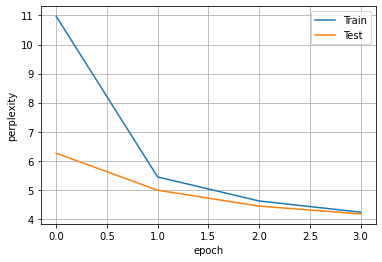

In [ ]:
oracle.cuda()

for epoch in range(4):
  current_losses = []
  for i, batch in enumerate(tqdm(traindataloader, total = len(traindataloader))):
    oracle.zero_grad()
    go, eos, mask, length = batch
    go, eos, mask = map(lambda x: x.cuda(), (go, eos, mask))
    prediction = oracle(
        go, length
    ).transpose(0, 1).transpose(1, 2)
    loss = (criterion(prediction, eos) * mask.float()).sum()
    loss = loss / mask.sum()
    loss.backward()
    #[x.grad.clamp_(-1,1) for x in oracle.parameters()]
    optimizer.step()
    current_losses.append(np.exp(loss.cpu().item()))
  losses.append(np.mean(current_losses))
  current_losses = []
  for i, batch in enumerate(tqdm(testdataloader, total = len(testdataloader))):
    oracle.zero_grad()
    go, eos, mask, length = batch
    go, eos, mask = map(lambda x: x.cuda(), (go, eos, mask))
    prediction = oracle(
        go, length
    ).transpose(0, 1).transpose(1, 2)
    loss = (criterion(prediction, eos) * mask.float()).sum()
    loss = loss / mask.sum()
    current_losses.append(np.exp(loss.item()))
  test_losses.append(np.mean(current_losses))
  clear_output(True)
  plt.plot(losses, label = 'Train')
  plt.plot(test_losses, label = 'Test')
  plt.xlabel('epoch')
  plt.ylabel('perplexity')
  plt.legend()
  plt.grid()
  plt.show()

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: